# A

In [1]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import kullback_leibler_divergence, SparseCategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq', 'msdai']:
    os.chdir('/home/ms/github/fxpred')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot, ts_train_test_normalize
from transformer_architecture_elements import Time2Vector, SingleAttention, MultiAttention, TransformerEncoder

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [2]:
dtype = np.float32  # np.float64
df = get_fx_and_metric_data_wo_weekend(dtype=dtype)
target = 'GBPUSD BGNE Curncy Bid Close'
target_column = list(df.columns).index(target)

df_close = get_fx_and_metric_data_wo_weekend(dtype=dtype, pct_change=False)
df = df.iloc[:, target_column : target_column + 1]

nn_type_classification = False
lag=128
h=1

In [3]:
def strategy(x):
    conditions = [
        (x <= -0.00000001),
        (x > -0.00000001) & (x <= 0.00000001),
        (x > 0.00000001)
    ]

    # create a list of the values we want to assign for each condition #!!! 
    values = ['sell', 'hold', 'buy']
    values = [0, 1, 2]

    # create a new column and use np.select to assign values to it using our lists as arguments #!!! 
    return np.select(conditions, values).astype(np.int32)
df['strategy'] = strategy(df[target])

df.head()

,GBPUSD BGNE Curncy Bid Close,strategy
Dates,,
2020-11-01 19:10:00,0.000000,1
2020-11-01 19:20:00,-0.002649,0
2020-11-01 19:30:00,0.000875,2
2020-11-01 19:40:00,0.000132,2
2020-11-01 19:50:00,-0.000023,0


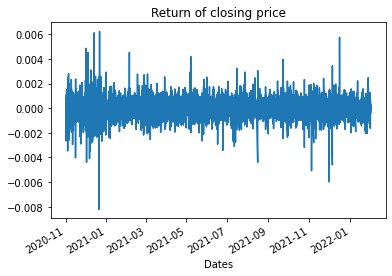

In [4]:
df[target].plot()
plt.title('Return of closing price')
plt.show()

In [5]:
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, 1)

In [6]:
X_train = sc.inverse_transform(X_train)
X_val = sc.inverse_transform(X_val)
X_test = sc.inverse_transform(X_test)
y_train = sc_target.inverse_transform(y_train)
y_val = sc_target.inverse_transform(y_val)
y_test = sc_target.inverse_transform(y_test)

In [7]:
def predictions(y):
    return y[:-1]

## Econmetric measures

Definition of cumulated returns

In [8]:
def cumulated_return(y_pred, ret, start_capital=1000, dtype=None):
    assert y_pred.flatten().shape == ret.flatten().shape
    balance = [start_capital]
    signal = 0
    for i, d in enumerate(y_pred[:-1]):
        signal = signal if d == 1 else d
        if signal == 0:
            balance.append(balance[-1])
        elif signal == 2:
            balance.append(balance[-1] * ret[i])
        else:
            raise ValueError()
    balance = np.array(balance, dtype=dtype)
    return balance

## read in data for econmic metric

In [9]:
def econ_metrics(y_pred, X_ret, risk_free=0.0031):  # Risk free rate must be given
    x = cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype)
    print(f'Portfolio return: {x[-1] / x[0] - 1}')
    print(f'Std of returns: {np.std(x[1:] / x[:-1])}')
    print(f'Sharpe ratio: {((x[-1] / x[0]) - 1 - risk_free) / np.std(x[1:] / x[:-1])}')
    print()
    
    n = 6 * 24 * 252  # banking days per year
    mu_annum = ((x[-1]/x[0]) ** (n / x.shape[0])) - 1
    print(f'Return per annum: {mu_annum}')
    std_annum = np.std(x[1:] / x[:-1]) * (n)**0.5
    print(f'Std of returns per annum: {std_annum}')
    print(f'Sharpe ratio per annum: {(mu_annum - risk_free) / std_annum}')

In [10]:
def investment_lengths(y):
    count_length = {0: [], 1: [], 2: []}
    length = 0
    current = y.flatten()[0]
    for i, t in enumerate(y.flatten()):
        if t == current:
            length += 1
        else:
            count_length[current].append(length)
            current = t
            length = 1
    return count_length
def investment_lengths_buy_sell(y):
    count_length = {0: [], 2: []}
    length = 0
    current = y.flatten()[0]
    for i, t in enumerate(y.flatten()):
        if t == current or t == 1:
            length += 1
        else:
            count_length[current].append(length)
            current = t
            length = 1
    return count_length
def changed_number_of_investments(v):
    return sum([len(v) for k, v in count_length.items()])
def investment_length_stats(v, dec_point=4):
    return {k: {'number': len(v), 'mean': np.mean(v).round(dec_point), 'std': np.std(v).round(dec_point), 'max': np.max(v)} for k, v in v.items() if v}

In [11]:
def result_output2(tmp_type):
    print(tmp_type)

    y = eval(f"y_{tmp_type}")[1:]
    y_pred = strategy(predictions(eval(f"y_{tmp_type}")))
    print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
    print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
    print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

#     X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, 0] + 1
    X_ret = eval(f"X_{tmp_type}")[:, -1, 0] + 1
    plt.plot(eval(f"index_{tmp_type}")[lag-1:-(h+1)][1:], cumulated_return(y_pred, X_ret[1:], dtype=dtype), label='predicted')

    p = [i[1]/y.shape[0] for i in sorted(Counter(y.flatten()).items(), key=lambda x: x[0])]
    x = np.concatenate(
        [
            cumulated_return(
                np.random.choice([0, 1, 2], size=y_pred.shape, p=p),
                X_ret[1:],
                dtype=dtype
            )[:,np.newaxis] for i in range(50)
        ], axis=-1
    )
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1), label='random', color='gray')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][2:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[2:], dtype=dtype), label='buy&HODL')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][2:], cumulated_return(y[:-1], X_ret[2:], dtype=dtype), label='oracle')
    plt.legend()
    plt.semilogy()
    plt.show()
    econ_metrics(y_pred, X_ret[:-1])
    print('=============================')
    print('Investment lengths')
    print('y_true')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths(y)), orient='index'))
    print('y_pred')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths(y_pred)), orient='index'))
    print('Investment lengths for only buy and sell (hold is prolongation of previous)')
    print('y_true')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths_buy_sell(y)), orient='index'))
    print('y_pred')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths_buy_sell(y_pred)), orient='index'))

train
Accuracy: 0.24978691339492798
Accuracy: 0.4800991714000702
KL_Divergence: -0.02996031753718853
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     18588
         1.0       0.02      0.26      0.03      1222
         2.0       0.46      0.49      0.48     18907

    accuracy                           0.25     38717
   macro avg       0.16      0.25      0.17     38717
weighted avg       0.23      0.25      0.24     38717



/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


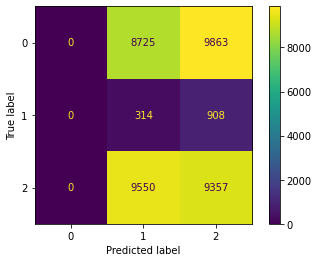

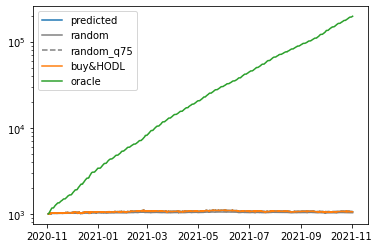

Portfolio return: 0.059064388275146484
Std of returns: 0.0004096240736544132
Sharpe ratio: 136.6237774451749

Return per annum: 0.05525982983540101
Std of returns per annum: 0.07803096695386431
Sharpe ratio per annum: 0.6684503841435212
Investment lengths
y_true
   number    mean     std  max
0    9863  1.8846  1.2695   13
1     616  1.9838  7.5889  154
2    9830  1.9233  1.2918   12
y_pred
   number    mean     std  max
1    9863  1.8846  1.2695   13
2    9863  2.0408  2.3532  154
Investment lengths for only buy and sell (hold is prolongation of previous)
y_true
   number    mean     std  max
0    9689  2.0058  2.4380  161
2    9689  1.9901  1.3767   15
y_pred


KeyError: 1

In [12]:
result_output2('train')

In [ ]:
# result_output2('val')

test
Accuracy: 0.2461375594139099
Accuracy: 0.4806349277496338
KL_Divergence: -0.00366041949018836
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2271
         1.0       0.02      0.33      0.04       156
         2.0       0.45      0.48      0.47      2298

    accuracy                           0.25      4725
   macro avg       0.16      0.27      0.17      4725
weighted avg       0.22      0.25      0.23      4725



/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


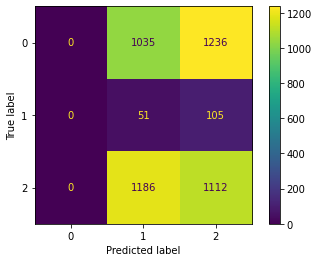

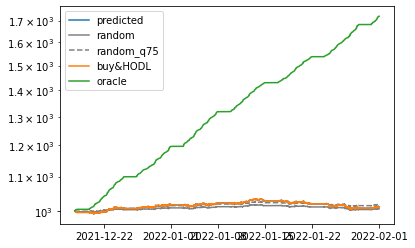

Portfolio return: 0.011111617088317871
Std of returns: 0.0003271857858635485
Sharpe ratio: 24.48644603301649

Return per annum: 0.08859138167597447
Std of returns per annum: 0.0623269599775331
Sharpe ratio per annum: 1.3716597393293595
Investment lengths
y_true
   number    mean     std  max
0    1236  1.8374  1.2162   10
1     108  1.4444  1.2644    6
2    1233  1.8621  1.2218   11
y_pred
   number    mean     std  max
1    1237  1.8367  1.2160   10
2    1236  1.9838  1.3527   11
Investment lengths for only buy and sell (hold is prolongation of previous)
y_true
   number    mean     std  max
0    1206  1.9527  1.3942   12
2    1206  1.9635  1.3197   11
y_pred


KeyError: 1

In [13]:
result_output2('test')